In [1]:
from gptopt.optim.attn_kq import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 1000

mu_scales = [0.1, 0.05]
beta = 0.01

In [4]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=n=1000$

In [5]:
m = n = 500
std2 = 1  
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)


mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=3.1630e+01, mu_max=3.8371e+01


In [6]:
residuals = {}
for mu_scale in mu_scales:
    mu_reg = max(mu_scale * mu_max, 1e-6)
    residuals[mu_scale] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter)

Method                 Obj          Viol
----------------------------------------
pdhg          -3.353198e-01  2.192163e-02
rehpdhg       -3.355429e-01  1.334658e-02
pdhg ds       -3.353191e-01  2.749242e-03
rehpdhg ds    -3.355731e-01  1.525839e-02
fista         -3.353234e-01  1.154745e-02
Method                 Obj          Viol
----------------------------------------
pdhg          -5.793610e-01  7.644424e-02
rehpdhg       -5.798757e-01  1.562003e-02
pdhg ds       -5.794407e-01  2.662221e-02
rehpdhg ds    -5.799335e-01  1.810936e-02
fista         -5.794498e-01  3.085004e-02


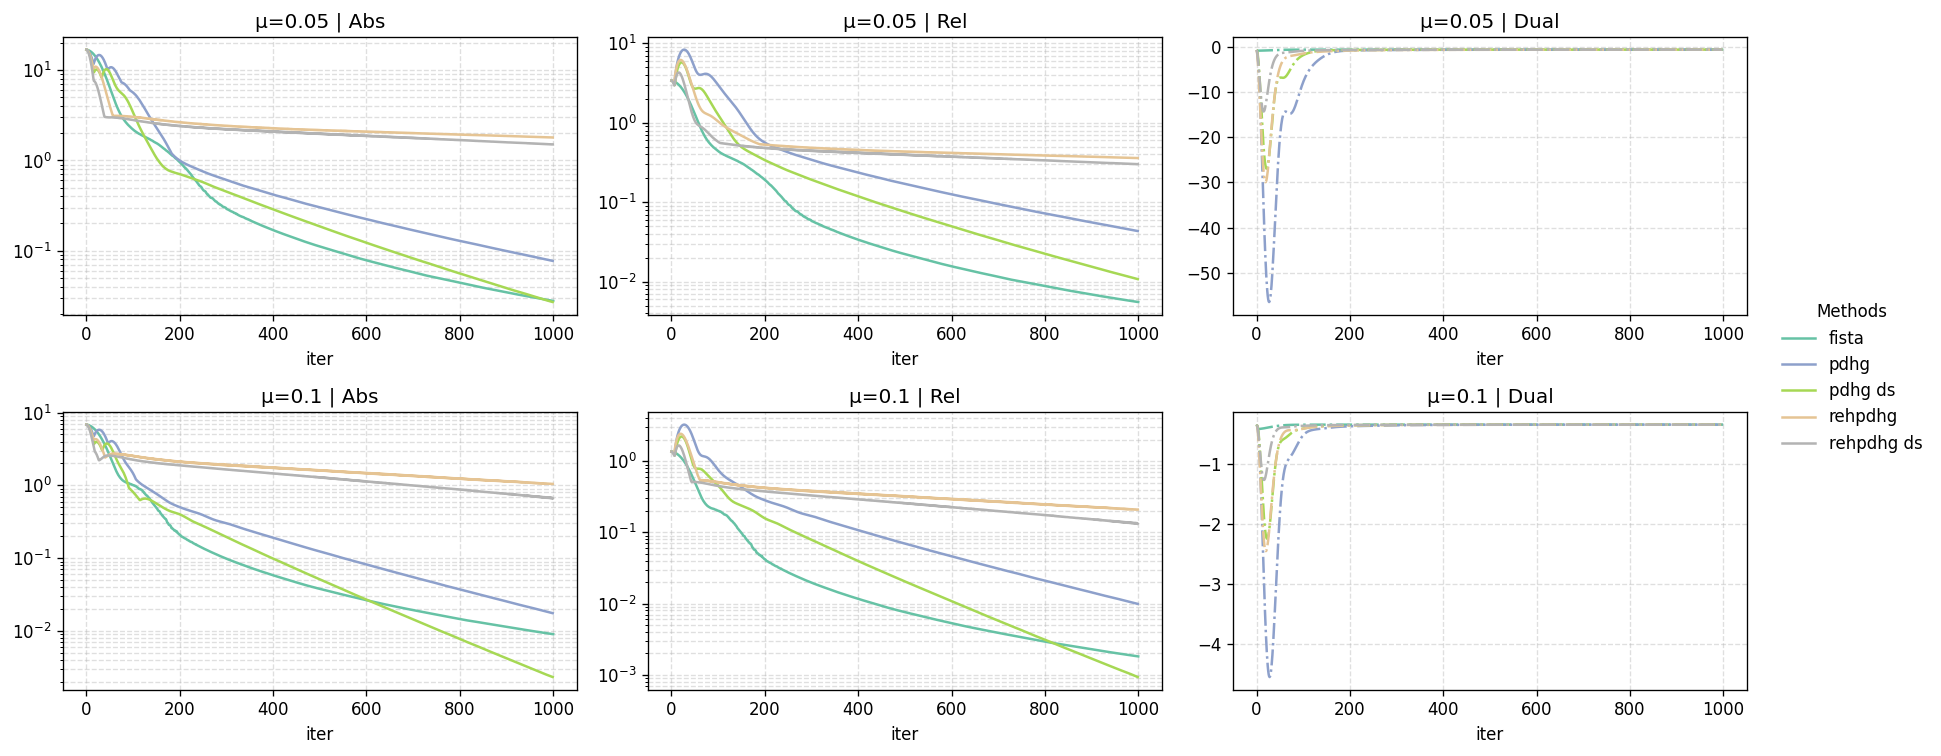

In [7]:
_ = plot_residuals_grid_by_param(residuals, param_name='mu')

#  $m=n=1000$

In [8]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=1.5127e-01, lamb_max=1.4142e+03, mu_max=3.0254e+00


In [9]:
residuals = {}
for mu_scale in mu_scales:
    mu_reg = max(mu_scale * mu_max, 1e-6)
    residuals[mu_scale] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter)

Method                 Obj          Viol
----------------------------------------
pdhg          -3.560549e-02  3.842858e-02
rehpdhg       -4.350666e-02  9.821706e-03
pdhg ds       -3.953364e-02  5.312187e-02
rehpdhg ds    -4.350531e-02  4.437543e-03
fista         -4.350479e-02  2.363843e-02
Method                 Obj          Viol
----------------------------------------
pdhg          -6.060534e-02  4.498854e-02
rehpdhg       -7.516775e-02  2.155581e-02
pdhg ds       -6.521825e-02  5.516184e-02
rehpdhg ds    -7.516177e-02  1.198908e-02
fista         -7.516192e-02  6.257387e-02


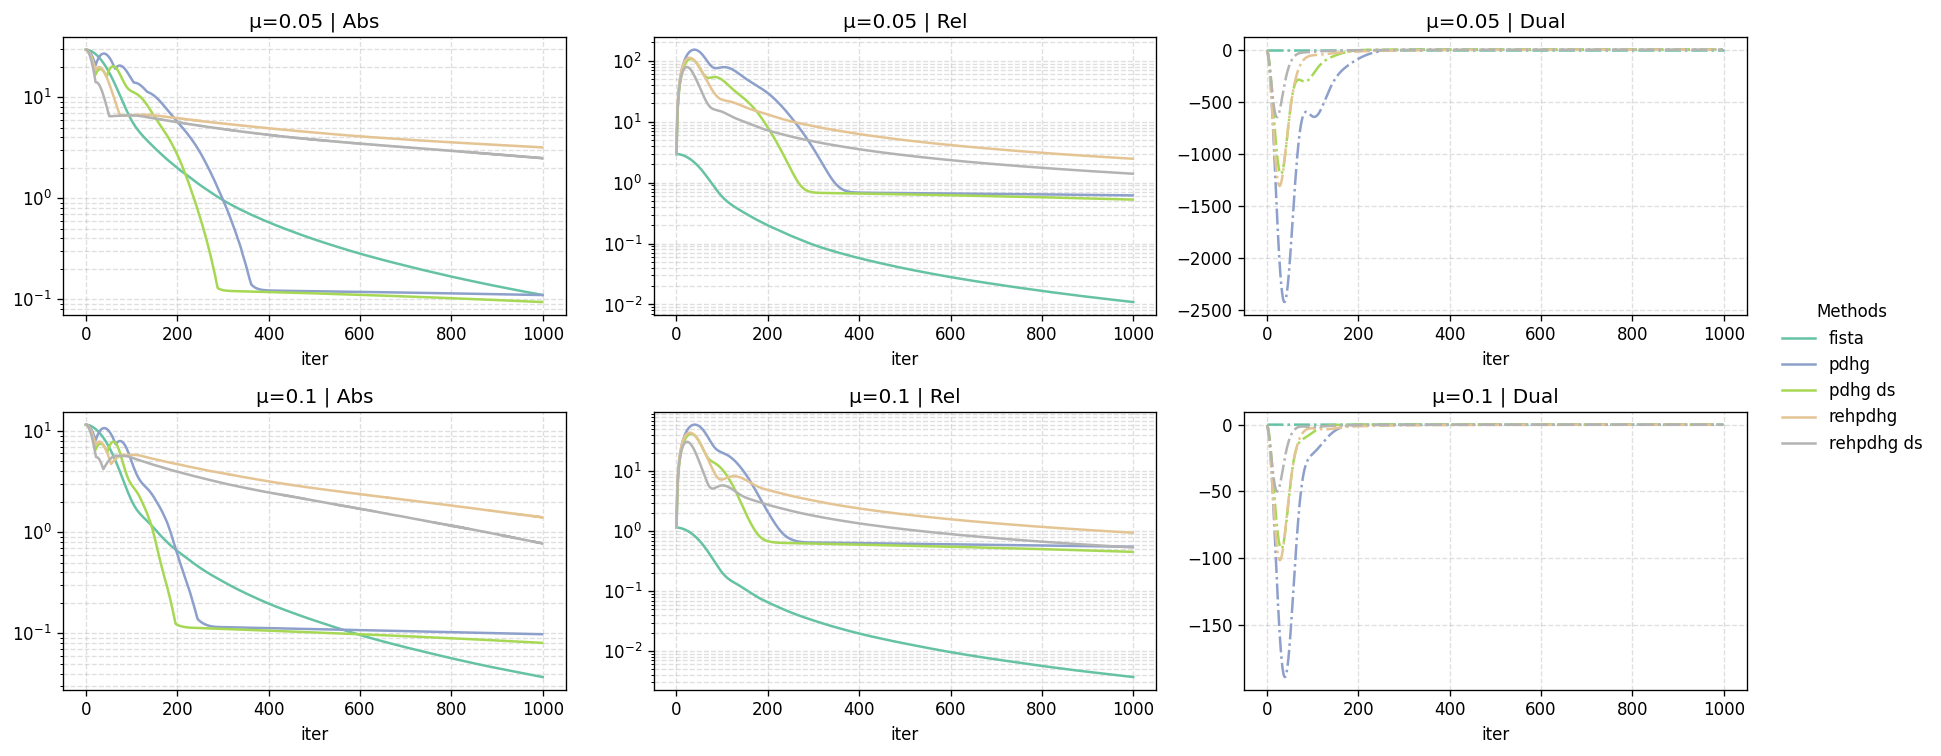

In [10]:
_ = plot_residuals_grid_by_param(residuals, param_name='mu')